# Pixel Bricks
## Turn your Image into a Pixel Brick Mural!
All you need to do is input your images file path and desired dimentions and you can see what your Pixel Brick Mural will look like! </br>
If you are using Jupyter from Anaconda in a fresh environment, be sure to run the pip line below.

I have only tested this with PNG and JPG files. 

In [1]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install fpdf2

Note: you may need to restart the kernel to use updated packages.


In [40]:
import os
import math
import itertools
from PIL import Image

class PixelifyImage():
    """
    Input Arguments:
    image_name: The file name in the "input_images" folder.  Include the ".jpg" or ".png"
    desired_output_dim: A Tuple of integers of length 2 representing the dimentions of the overall output image.  i.e. (64,64) means a 64x64 stud mural.
    plate_dim: A Tuple of ingegers of length 2 representing the size of the smaller plates used to create the mural. This number must be devisible by the input image or the instructions will not come out correct. i.e. (32,32) for the above 64x64 example.
    
    Notable Output Arguments or Methods:
    self.save_image(): Saves the downsized and mocked up images to the "output_images" folder.
    self.mock_up: 1000x1000 full sized image mock up of the pixelified image.
    self.pieces_needed: A dictionary containing the number of each colored brick used.
    self.instruction_data: A dictionary containing the brick murals RGB data for each panel.
    self.instruction_text: A dictionary containing the brick murals color in text for each panel.
    """
    def __init__(self,image_name, desired_output_dim, plate_dim):
        # desired_output_dim is a Tuple of integers
        # image_name needs to have the type suffix on it (i.e. .jpg or .png)
        self.path = os.getcwd() 
        self.file_name = image_name.split('.')[0]
        # If you want to experiment with fewer colors, just comment them out of this variable.
        self.color_options = {
            "Black":(5, 19, 29),
            "White":(255, 255, 255),
            "Flat Silver":(137, 135, 136),
            "Medium Stone Grey": (160, 165, 169),
            "Pearl Dark Grey":(87, 88, 87),
            "Tan":(228, 205, 158),
            "Flesh":(208, 145, 104),
            "Pearl Gold":(170, 127, 46),
            "Medium Dark Flesh":(170, 125, 85),
            "Redish Brown":(88, 42, 18),
            "Yellow":(242, 205, 55),
            "Bright Light Yellow":(255, 240, 58),
            "Orange":(254, 138, 24),
            "Dark Orange":(169, 85, 0),
            "Bright Light Orange":(248, 187, 61),
            "Red":(201, 26, 9),
            "Bright Pink":(228, 173, 200),
            "Dark Red":(114, 14, 15),
            "Olive Green":(155, 154, 90),
            "Green":(35, 120, 65),
            "Bright Green":(75, 159, 74),
            "Dark Turquoise":(0, 143, 155),
            "Lime":(187, 233, 11),
            "Yellowish Green":(223, 238, 165),
            "Blue":(0, 85, 191),
            "Light Aqua":(173, 195, 192),
            "Dark Turquoise":(0, 143, 155),
            "Dark Blue":(10, 52, 99),
            "Medium Azure":(54, 174, 191),
            "Dark Purple":(63, 54, 145),
            "Medium Lavender":(172, 120, 186),
            }
        # There is probably a better way to do the conversion, but this will do for now...  If I made a database, I could just reverse the creation of the dictionary in memory when I query the colors.
        self.convert_back = {
            (5, 19, 29):"Black",
            (255, 255, 255):"White",
            (137, 135, 136):"Flat Silver",
            (160, 165, 169):"Medium Stone Grey",
            (87, 88, 87):"Pearl Dark Grey",
            (228, 205, 158):"Tan",
            (208, 145, 104):"Flesh",
            (170, 127, 46):"Pearl Gold",
            (170, 125, 85):"Medium Dark Flesh",
            (88, 42, 18):"Redish Brown",
            (242, 205, 55):"Yellow",
            (255, 240, 58):"Bright Light Yellow",
            (254, 138, 24):"Orange",
            (169, 85, 0):"Dark Orange",
            (248, 187, 61):"Bright Light Orange",
            (201, 26, 9):"Red",
            (228, 173, 200):"Bright Pink",
            (114, 14, 15):"Dark Red",
            (155, 154, 90):"Olive Green",
            (35, 120, 65):"Green",
            (75, 159, 74):"Bright Green",
            (0, 143, 155):"Dark Turquoise",
            (187, 233, 11):"Lime",
            (223, 238, 165):"Yellowish Green",
            (0, 85, 191):"Blue",
            (173, 195, 192):"Light Aqua",
            (0, 143, 155):"Dark Turquoise",
            (10, 52, 99):"Dark Blue",
            (54, 174, 191):"Medium Azure",
            (63, 54, 145):"Dark Purple",
            (172, 120, 186):"Medium Lavender",
            }
        self.plate_dim = plate_dim
        self.palette = list(self.color_options.values())
        self.original_image = Image.open(self.path + "\\input_images\\" + image_name)
        self.desired_output_dim = desired_output_dim
        self.resized_image = self.original_image.resize(desired_output_dim)
        self.resized_img_lst = self.get_pixel_values()
        self.pixelated_image_list = []
        self.pixelify()
        self.pixelified_image = self.create_image_from_pixels()
        self.pieces_needed = {}
        self.count_pieces()
        self.make_brick_mock_up()
        self.create_instruction_data()
        
        # self.save_image()
    
    def get_pixel_values(self):
        pixel_values = list(self.resized_image.getdata())
        return pixel_values

    def distance(self, c1, c2):
        # This try except block handles jpg vs pngs (jpg has no 4th translucency coef)
        try: 
            (r1,g1,b1,d) = c1
        except:
            (r1,g1,b1) = c1
        (r2,g2,b2) = c2
        return math.sqrt((r1 - r2)**2 + (g1 - g2) ** 2 + (b1 - b2) **2)

    def pixelify(self):
        for i, p in enumerate(self.resized_img_lst):
            dists = []
            for c in self.palette:
                dists.append(self.distance(p, c))
            closest_i = dists.index(min(dists))
            r,g,b = self.palette[closest_i]
            self.pixelated_image_list.append((r,g,b,255))    
    
    def make_brick_mock_up(self, section = 0):
        if section == 0:
            pixel_blank = Image.new("RGB", (80*(self.desired_output_dim[0]),80*self.desired_output_dim[1]))
        else :
            pixel_blank = Image.new("RGB", (80*self.plate_dim[0],80*self.plate_dim[1]))
        button_path = self.path + "\\stud\\white.png"
        white_circle = Image.open(button_path)
        x = 0
        y = 0
        if section == 0:
            for i in self.pixelated_image_list:
                position = (x,y)
                
                pixel_color = (i[0],i[1],i[2])
                pixel_values = list(white_circle.getdata())
                for n,p in enumerate(pixel_values):
                    if p != (0,0,0):
                        pixel_values[n] = pixel_color
                # This is super ineffiecnt (timewise), but was convenient to quickly create a mock up.  Should fix.
                colored_round_image = self.create_rounds(pixel_values)    
                pixel_blank.paste(colored_round_image, position)
                x += 80
                if x >= pixel_blank.width:
                    # print(pixel_color)
                    x = 0
                    y += 80
            self.mock_up = pixel_blank.resize((1000,1000))
            
        else:
            c = 0
            # len(section)
            for i in section:
                position = (x,y)
                
                pixel_color = (i[0],i[1],i[2])
                pixel_values = list(white_circle.getdata())
                for n,p in enumerate(pixel_values):
                    if p != (0,0,0):
                        pixel_values[n] = pixel_color
                # This is super ineffiecnt (timewise), but was convenient to quickly create a mock up.  Should fix.
                colored_round_image = self.create_rounds(pixel_values)  
                c += 1
                pixel_blank.paste(colored_round_image, position)
                x += 80
                if x >= pixel_blank.width:
                    x = 0
                    y += 80
        return pixel_blank

    def count_pieces(self):
        for (r,g,b,d) in self.pixelated_image_list:
            name = list(self.color_options.keys())[list(self.color_options.values()).index((r,g,b))]
            if name not in self.pieces_needed.keys():
                self.pieces_needed[name] = 1
            else:
                self.pieces_needed[name] += 1
        self.pieces_needed = dict(sorted(self.pieces_needed.items(), key=lambda item: item[1]))

    def create_rounds(self, pixels):
        # Create a new image with the specified size and mode (RGB)
        new_image = Image.new("RGB", (80,80))
        # Put the pixel values into the image
        new_image.putdata(pixels)
        return new_image

    def create_image_from_pixels(self):
        # Create a new image with the specified size and mode (RGB)
        new_image = Image.new("RGB", self.desired_output_dim)
        # Put the pixel values into the image
        new_image.putdata(self.pixelated_image_list)
        return new_image

    def create_instruction_data(self):
        # You must use evenly divisible plates to your image size, or the image will bias to the top left.
        x_dim, y_dim = self.plate_dim
        
        pos = 0
        self.instructions_text = {}
        self.instructions_data = {}
        
        plate_row_id = 0
        plate_column_id = 0
        row = 0
        
        for i in range(int(len(self.pixelated_image_list)/x_dim)):
            row_data = self.pixelated_image_list[int(((((plate_row_id*y_dim)+row)*(self.desired_output_dim[0]/x_dim))+plate_column_id)*x_dim):int(((((plate_row_id*y_dim)+row)*(self.desired_output_dim[0]/x_dim))+plate_column_id)*x_dim+x_dim)]
            
            row_data_colors = []
            for pixel in row_data:
                no_t = (pixel[0],pixel[1],pixel[2])
                color = self.convert_back[no_t]
                row_data_colors.append(color)
            something = self.instructions_text.get(f"plate_{plate_row_id}{chr(ord('`')+(plate_column_id+1))}")
            
            if something:
                prior_data = self.instructions_data[f"plate_{plate_row_id}{chr(ord('`')+(plate_column_id+1))}"]
                prior_data.append(row_data)
                
                prior_text = self.instructions_text[f"plate_{plate_row_id}{chr(ord('`')+(plate_column_id+1))}"]
                prior_text.append(row_data_colors)
                
                self.instructions_data[f"plate_{plate_row_id}{chr(ord('`')+(plate_column_id+1))}"] = prior_data
                self.instructions_text[f"plate_{plate_row_id}{chr(ord('`')+(plate_column_id+1))}"] = prior_text
            else:
                self.instructions_text[f"plate_{plate_row_id}{chr(ord('`')+(plate_column_id+1))}"] = [row_data_colors]
                self.instructions_data[f"plate_{plate_row_id}{chr(ord('`')+(plate_column_id+1))}"] = [row_data]
            
            pos += x_dim
            plate_column_id += 1
            if pos >= self.desired_output_dim[0]:
                pos = 0
                row += 1
                plate_column_id = 0
            if row == y_dim:
                plate_row_id += 1
                row = 0      

    def save_image(self):
        self.pixelified_image.save(f"output\pixelated_{self.file_name}_{self.desired_output_dim[0]}_by_{self.desired_output_dim[1]}.jpg")
        self.mock_up.save(f"output\\brickified_{self.file_name}_{self.desired_output_dim[0]}_by_{self.desired_output_dim[1]}.jpg")
        



In [41]:
from fpdf import FPDF

class PDF(FPDF):
    """
    Input Argument:
    pixel_image: A PixelifyImage instance.
    """
    def __init__(self, pixel_image):
        super().__init__()
        self.pixel_image = pixel_image
        self.front_page()
        self.instruction_pages()
        self.save_pdf()
        
    def footer(self):
        # Position cursor at 1.5 cm from bottom:
        self.set_y(-10)
        # Setting font: helvetica italic 8
        self.set_font("helvetica", "I", 8)
        # Printing page number:
        self.cell(0, 8, f"Page {self.page_no()}/{{nb}}", align="C")
    
    def front_page(self):
        self.add_page()
        # There is a format issue with FPDF, but resetting the margins doesnt fix the weird wrapping issue.
        # self.set_margins(8,8)
        self.set_font('helvetica', size=36)
        # Once the instructions are internal to the image class, I should also add the Plate count to the equation
        self.cell(text=f"Your mosaic needs {self.pixel_image.desired_output_dim[0] * self.pixel_image.desired_output_dim[1]} Studs!", center=True)
        self.ln(12)
        self.set_font('helvetica', size=12)
        self.image(self.pixel_image.mock_up,None, None, w=self.epw)
        self.ln(6)
        self.cell(text="Your color breakdown is as follows:")
        self.ln(6)
        line_height = self.font_size * 2
        col_width = self.epw / 8
        x = 0
        for i,needed in enumerate(self.pixel_image.pieces_needed.keys()):
            if i%8 == 0 and i !=0:
                self.ln(line_height)
                # print(x, i)
                for j in range(x,i):
                    self.multi_cell(
                    col_width,
                    line_height,
                    str(self.pixel_image.pieces_needed[list(self.pixel_image.pieces_needed.keys())[j]]),
                    border=1,
                    align = 'C',
                    new_y="TOP",
                    max_line_height=self.font_size,
                    )
                x += 8
                # print(x)
                self.ln(line_height)
                
                    
            self.multi_cell(
                col_width,
                line_height,
                needed,
                border=1,
                align = 'C',
                new_y="TOP",
                max_line_height=self.font_size,
            )
        # print(i)
        if i > x:
            self.ln(line_height)
            for j in range(x,i+1):
                self.multi_cell(
                col_width,
                line_height,
                str(self.pixel_image.pieces_needed[list(self.pixel_image.pieces_needed.keys())[j]]),
                border=1,
                align = 'C',
                new_y="TOP",
                max_line_height=self.font_size,
                )
            self.ln(line_height)

    def instruction_pages(self):
        line_height = self.font_size * 2
        col_width = self.epw / 8
        for panel in self.pixel_image.instructions_data.keys():
            self.add_page()
            self.set_font('helvetica', size=36)
            self.cell(text=f"Plate: {panel.split('_')[-1]}", center=True)
            self.ln(line_height*1.5)
            self.set_font('helvetica', size=12)
            sub = list(itertools.chain.from_iterable(self.pixel_image.instructions_data.get(panel)))
            self.image(self.pixel_image.make_brick_mock_up(sub), None, None, w=self.epw)
            # display(pixel_image.make_brick_mock_up(sub))
            sub_text = self.pixel_image.instructions_text
            # print(sub_text[panel])
            self.ln(line_height/2)
            for n, row in enumerate(sub_text[panel]):
                y = self.get_y()
                if y >= 250:
                    self.add_page()
                self.cell(text=f"Row {n}")
                self.ln(line_height/2)
                i = 0
                for p in row:
                    if i%8 == 0 and i !=0:
                        self.ln(line_height)
                            
                    self.multi_cell(
                        col_width,
                        line_height,
                        p,
                        border=1,
                        align = 'C',
                        new_y="TOP",
                        max_line_height=self.font_size,
                    )
                    i += 1
                self.ln(line_height*2.5)

    def save_pdf(self):
        self.output(f"{self.pixel_image.path}\output\{self.pixel_image.file_name}.pdf")
        

## I mashed up two images of Frieza to show how lazy editing with paint can help improve output quality

{'Bright Pink': 1, 'Bright Light Yellow': 2, 'White': 4, 'Tan': 6, 'Medium Dark Flesh': 7, 'Flesh': 7, 'Lime': 8, 'Bright Green': 8, 'Yellowish Green': 8, 'Dark Orange': 19, 'Green': 19, 'Yellow': 20, 'Medium Stone Grey': 21, 'Medium Lavender': 27, 'Flat Silver': 33, 'Light Aqua': 39, 'Olive Green': 54, 'Dark Purple': 77, 'Medium Azure': 162, 'Blue': 174, 'Dark Turquoise': 181, 'Pearl Gold': 194, 'Pearl Dark Grey': 308, 'Redish Brown': 556, 'Dark Blue': 601, 'Black': 1560}


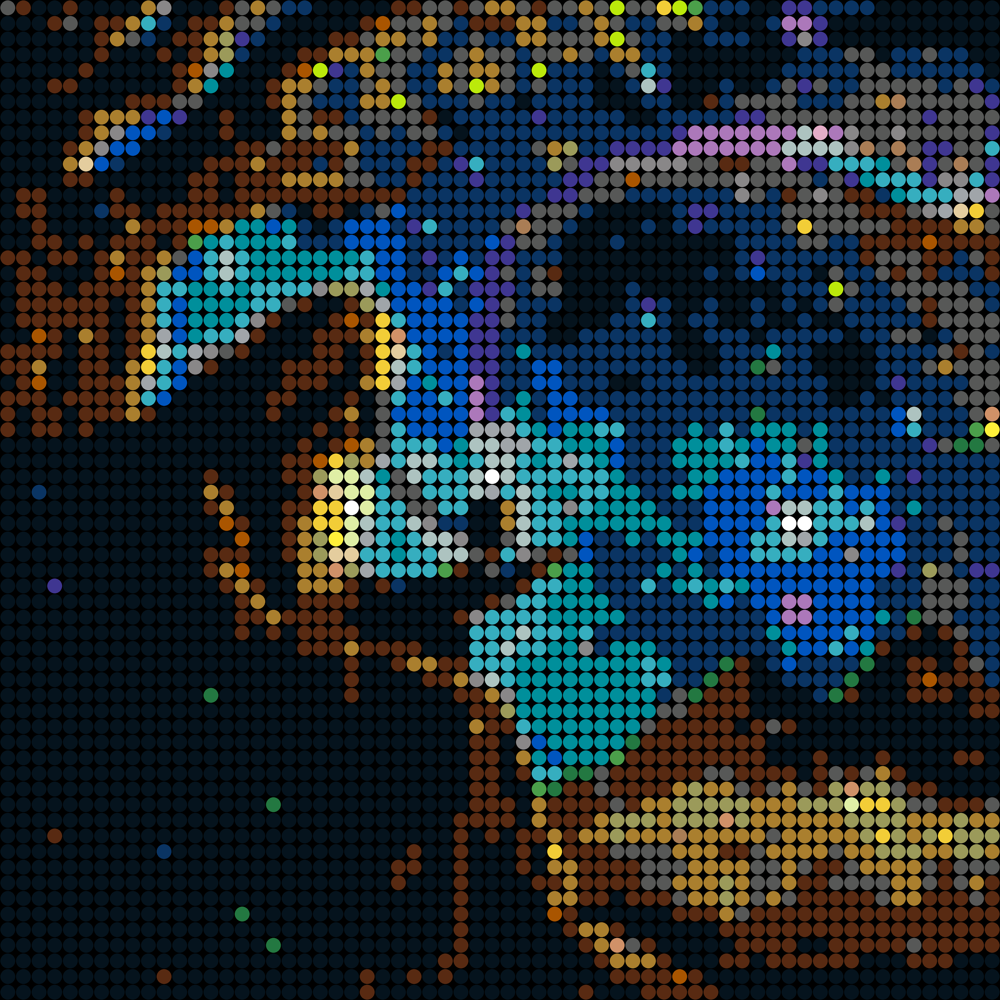

In [48]:
gandalf_image = PixelifyImage("gandalf_night_sky.png", (64,64),(32,32))
print(gandalf_image.pieces_needed)
gandalf_image.mock_up

In [45]:
gandalf_image.save_image()

In [49]:
gandalf_pdf = PDF(gandalf_image)